## Tractography : probabilistic tracking

Considering that the SNR of the measurement is pretty low, and that the information about directions of fascicles that we get in every voxel is not that accurate, we might want to consider this information with a grain of salt. One way to do that is to treat the directions provided by the [reconstruction](DTI.ipynb) [algorithms](SFM.ipynb) as the modes of a probability distribution and, in each iteration of our tracking algorithm, sample from this probability distribution. This also has the benefit that it allows us to track through locations in which the directional signal to the reconstruction algorithms is not as clear, due to SNR issues, or due to spatial and directional resolution of measurement. This approach, pioneered by Behrens et al [1] is called "probabilistic tractography". 

[1] Behrens, T E J, H Johansen-Berg, M W Woolrich, S M Smith, C A M Wheeler-Kingshott, P A Boulby, G J Barker, et al. 2003. “Non-Invasive Mapping of Connections between Human Thalamus and Cortex Using Diffusion Imaging.” Nature Neuroscience 6: 750–57.

In [1]:
import os.path as op
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

import dipy.core.gradients as grad
from dipy.data import get_sphere
from dipy.reconst.csdeconv import auto_response
from dipy.reconst import sfm, dti
from dipy.io.trackvis import save_trk
from dipy.reconst.peaks import peaks_from_model
from dipy.data import small_sphere
from dipy.io.trackvis import save_trk
from dipy.direction import ProbabilisticDirectionGetter
from dipy.tracking.local import ThresholdTissueClassifier
from dipy.tracking.local import LocalTracking

from IPython.display import display, Image

In [2]:
dwi_ni = nib.load(op.join('data', 'SUB1_b2000_1.nii.gz'))
LV1_ni = nib.load(op.join('data', 'SUB1_LV1.nii.gz'))
labels_ni = nib.load(op.join('data', 'SUB1_aparc-reduced.nii.gz'))

data = dwi_ni.get_data()
affine = dwi_ni.get_affine()

LV1_data = LV1_ni.get_data()
labels = labels_ni.get_data()

In [3]:
gtab = grad.gradient_table(op.join('data', 'SUB1_b2000_1.bvals'), op.join('data', 'SUB1_b2000_1.bvecs'))

In [4]:
white_matter =  (labels == 1) | (labels == 2)
V1 = (LV1_data == 1)

In [5]:
response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

In [6]:
sphere = get_sphere()
sf_model = sfm.SparseFascicleModel(gtab, sphere=sphere,
                                   l1_ratio=0.5, alpha=0.001,
                                   response=response[0])

We're going to fit the model in the entire white matter in the following cell, so this might take a little while to run:

In [7]:
sf_fit = sf_model.fit(data, mask=white_matter)

/Users/arokem/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Probabilistic tracking requires a mechanism to sample directions from the distribution of directions provided by the model. 

In this case 

In [8]:
fodf = sf_fit.odf(small_sphere)
prob_dg = ProbabilisticDirectionGetter.from_pmf(fodf, max_angle=30., sphere=small_sphere)

As in the determinstic tracking, we need an object that will terminate tracking based on tissue classification. Again, we will use the `TheresholdTissueClassifier` with FA>0.1

In [9]:
classifier = ThresholdTissueClassifier(white_matter.astype(float), 0.0)

We'll seed the tracking at the pre-defined V1 ROI. We distribute plenty of seeds around V1: 8 in every voxel in the ROI, distributed as `[2, 2, 2]`, that is at a sampling rate of 2x2x2 in each voxel, along each dimension (x/y/z).

In [10]:
import scipy.ndimage as ndi

In [11]:
np.unique(V1.astype(int))

array([0, 1])

Our ROI resides in the gray matter, so we need to dilate it a little bit into the white matter. This gives as an ROI that contains not only gray matter voxels, but also the white-matter voxels that are adjacent to this part of cortex

In [12]:
V1_smoothed = ndi.gaussian_filter(V1.astype(float), sigma=0.25).astype(bool)

In [13]:
np.where(V1_smoothed)

(array([28, 28, 28, ..., 39, 39, 39]),
 array([12, 12, 12, ..., 27, 27, 27]),
 array([30, 31, 32, ..., 33, 34, 35]))

In [14]:
from dipy.tracking import utils
seeds = utils.seeds_from_mask(V1_smoothed, density=[2, 2, 2], affine=affine)

In [15]:
streamlines = LocalTracking(prob_dg, classifier, seeds, affine, step_size=.5)

Finally, we are ready to perform the tracking itself. Tracking will be based on all the elements that we have defined so far. In the course of tracking, we will take steps of 0.5 mm. 

In [16]:
len_th = 10

streamlines = [s for s in streamlines if s.shape[0]>len_th]

In [17]:
len(streamlines)

5563

In [18]:
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors
from dipy.data import read_stanford_t1
from dipy.tracking.utils import move_streamlines
from numpy.linalg import inv
t1 = nib.load(op.join('data', 'SUB1_t1_resamp.nii.gz'))
t1_data = t1.get_data()
t1_aff = t1.get_affine()
color = line_colors(streamlines)

In [19]:
streamlines_actor = fvtk.streamtube(
                    list(move_streamlines(streamlines, inv(t1_aff))),
                                    line_colors(streamlines))

In [20]:
vol_actor = fvtk.slicer(t1_data, voxsz=(1.0, 1.0, 1.0), plane_i=[40],
                        plane_j=None, plane_k=[25], outline=False)

ren = fvtk.ren()
fvtk.add(ren, streamlines_actor)
fvtk.add(ren, vol_actor)
fvtk.camera(ren, viewup=(1,0,1), verbose=False)
fvtk.record(ren, out_path='prob-track.png', size=(600,600))

In [21]:
#fvtk.show(ren)

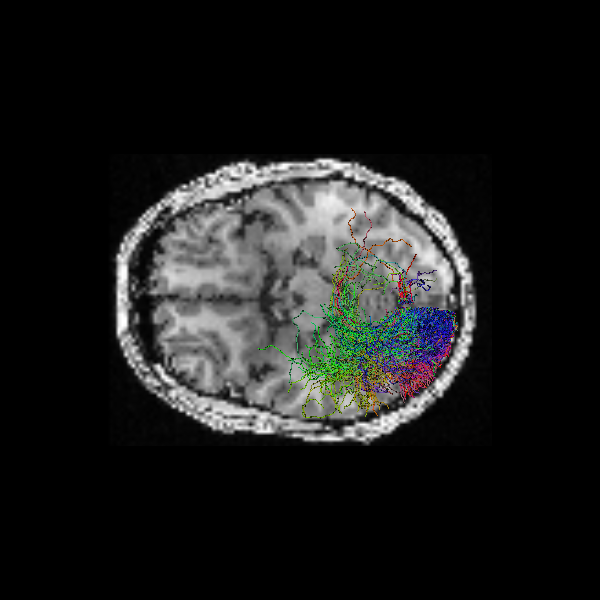

In [22]:
display(Image(filename='prob-track.png'))

In [23]:
save_trk("prob-track.trk", streamlines, affine, data.shape[:3])